In [1]:
import shap
import joblib
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

C:\Users\Administrator\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# 0. OUTPUT FOLDERS
os.chdir(r"D:\PAU document\Thesis\Analysis\Raster Datas\Input_Machine")
output_dir = os.path.join(os.getcwd(), "Machine_Output")
shap_dir = os.path.join(output_dir, "shap")
os.makedirs(shap_dir, exist_ok=True)

In [3]:
# 1. LOAD CSV
df = pd.read_csv("Input_raster_variables_observed.csv")
print(df.head())
print(df.shape)

     row   col         Flood        DEM     Aspect        LST  Curvature  \
0   1446   466  1.000000e+00  1091.4434  265.63922  30.465733  -0.882296   
1  12547  9845  0.000000e+00  2293.2332  195.32118  28.970543   1.117341   
2  10611  2922  1.460000e-11  1922.4335  225.00000  31.864056   0.000000   
3   7115  9716  0.000000e+00  1845.0000  146.19232  27.195745  -0.029038   
4   7020  7712  0.000000e+00  1785.0845  310.98590  21.077883  -0.420258   

   Hillshade      LULC        River         Road  Soil      Slope      SPI3  \
0  208.57971  4.562726   544.478638  2262.171143  22.0  19.355185 -0.001683   
1  169.44194  3.783454  2491.819580    58.499249   7.0   6.201397 -0.014699   
2  179.00000  5.000000  2012.050659   780.587463  12.0   6.091237 -0.008495   
3  180.09074  3.561093   106.502472  2710.281006   9.0   0.767772 -0.017318   
4  184.74039  5.000000  1619.145996  6337.947266  18.0   1.712441 -0.015713   

    Rainfall  
0  262.11862  
1  238.07439  
2  298.51373  
3  242.9

## SHAP Summary

In [16]:
# Collect models into a dictionary
models = {
    "RandomForest": rf_model,
    "XGBoost": xgb_model,
    "DecisionTree": dt_model,
    "LightGBM": lgbm_model
}

In [23]:
# Sample for SHAP (speed up plotting)
X_sample = shap.sample(X_train,1500, random_state=42)

shap_values_models = {}

for name, model in models.items():
    print(f"Computing SHAP values for {name}...")

    explainer = shap.TreeExplainer(
        model,
        feature_perturbation="tree_path_dependent"
    )

    shap_values = explainer.shap_values(
        X_sample,
        check_additivity=False
    )

    # Binary classification → select Flood class (1)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]

    shap_values_models[name] = shap_values

Computing SHAP values for RandomForest...
Computing SHAP values for XGBoost...
Computing SHAP values for DecisionTree...
Computing SHAP values for LightGBM...


In [18]:
# 4. GLOBAL FONT

plt.rcParams["font.family"] = "Times New Roman"

## Shap Waterfall


### SHAP Waterfall Plot: RandomForest ###


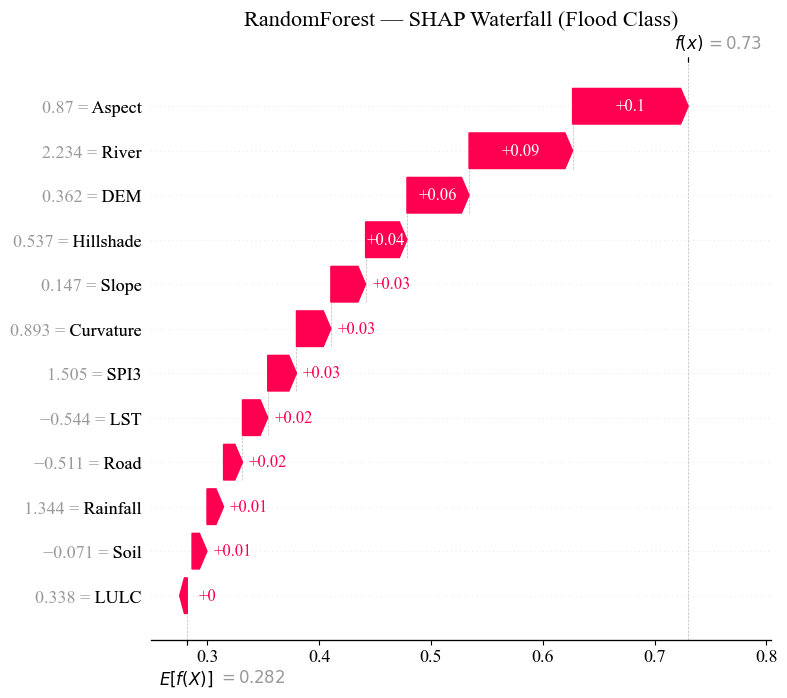

Saved to: D:\PAU document\Thesis\Analysis\Raster Datas\Input_Machine\Machine_Output\RandomForest_SHAP_waterfall.png

### SHAP Waterfall Plot: XGBoost ###


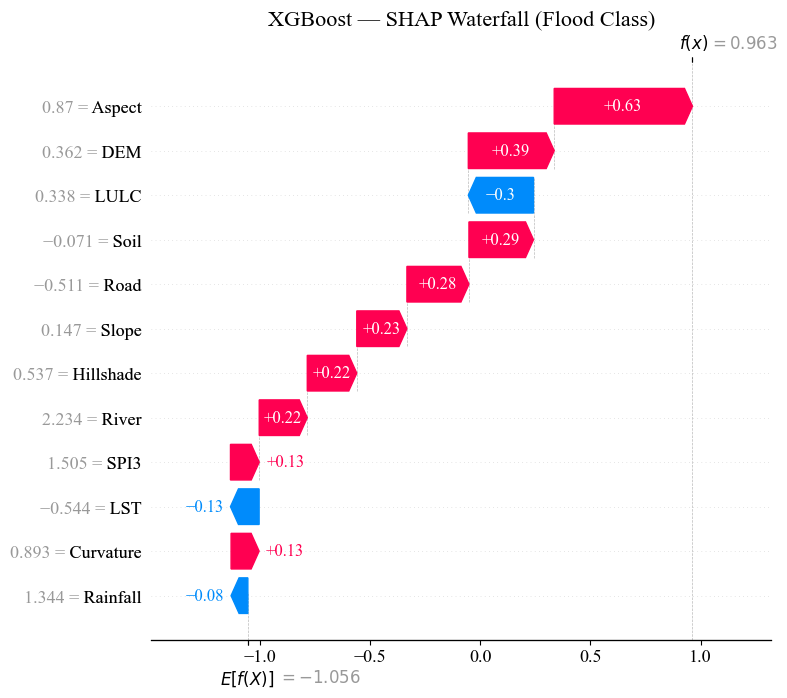

Saved to: D:\PAU document\Thesis\Analysis\Raster Datas\Input_Machine\Machine_Output\XGBoost_SHAP_waterfall.png

### SHAP Waterfall Plot: DecisionTree ###


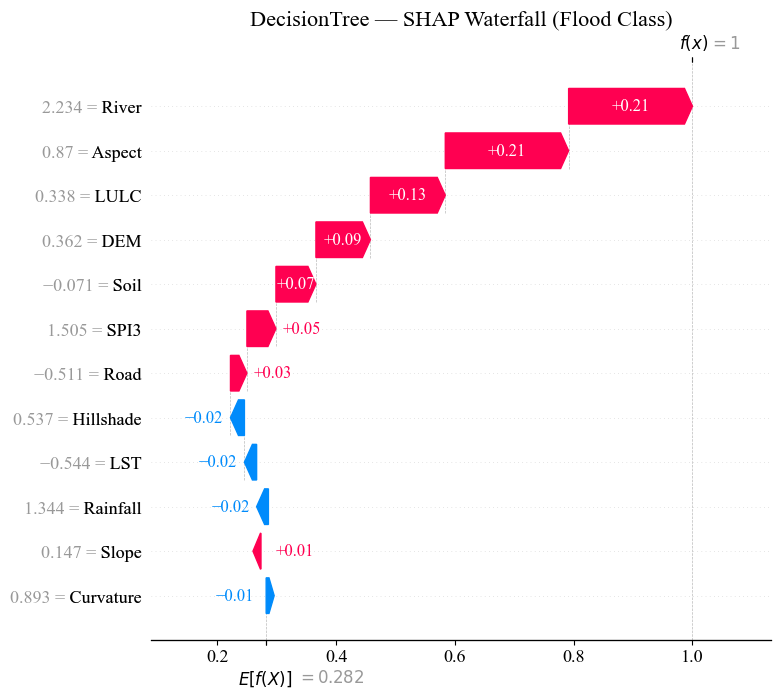

Saved to: D:\PAU document\Thesis\Analysis\Raster Datas\Input_Machine\Machine_Output\DecisionTree_SHAP_waterfall.png

### SHAP Waterfall Plot: LightGBM ###


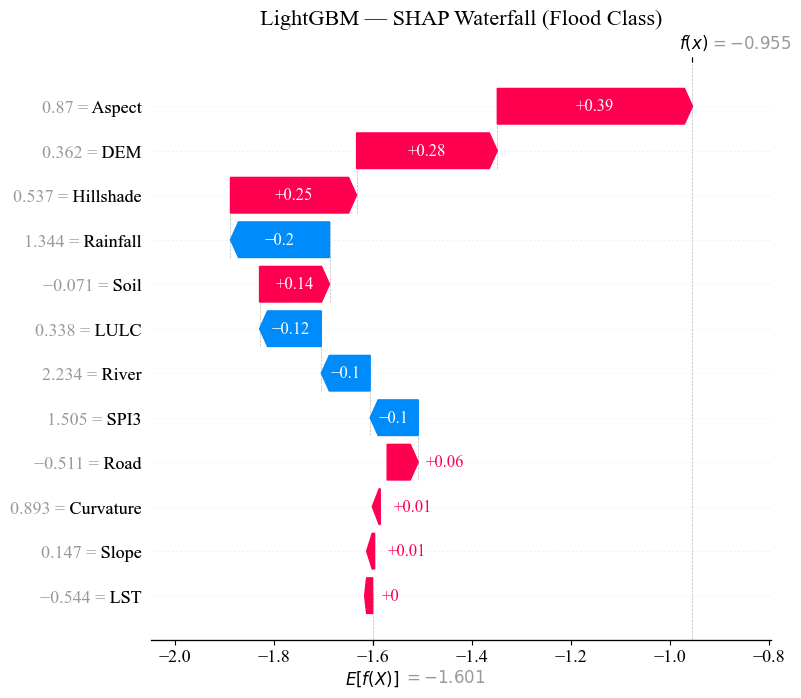

Saved to: D:\PAU document\Thesis\Analysis\Raster Datas\Input_Machine\Machine_Output\LightGBM_SHAP_waterfall.png


In [28]:
# ---------------------------------------------
# SELECT ONE FLOOD SAMPLE
# ---------------------------------------------

sample_idx = np.where(y_train == 1)[0][0]

X_instance = X_train[sample_idx]
X_instance_df = pd.DataFrame([X_instance], columns=feature_names)

# ---------------------------------------------
# WATERFALL SHAP (ROBUST VERSION)
# ---------------------------------------------

for name, model in models.items():
    print(f"\n### SHAP Waterfall Plot: {name} ###")

    explainer = shap.TreeExplainer(model)

    shap_exp = explainer(X_instance_df)

    # 🔑 HANDLE BOTH SHAP OUTPUT TYPES
    if len(shap_exp.shape) == 3:
        # XGBoost / LightGBM → select Flood class (1)
        shap_single = shap_exp[0, :, 1]
    else:
        # RandomForest / DecisionTree → already Flood class
        shap_single = shap_exp[0]

    plt.figure(figsize=(9, 6))

    shap.plots.waterfall(
        shap_single,
        max_display=15,
        show=False
    )

    plt.title(f"{name} — SHAP Waterfall (Flood Class)", fontsize=16)

    output_path = os.path.join(output_dir, f"{name}_SHAP_waterfall.png")
    plt.savefig(output_path, dpi=300, bbox_inches="tight")

    plt.show()
    plt.close()

    print(f"Saved to: {output_path}")